STEP I: Data Import & Preprocessing

In [168]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import operator
%matplotlib inline
plt.style.use('bmh')
from sodapy import Socrata

#get Chicago data
client = Socrata("data.cityofchicago.org", None)

inspect = client.get("4ijn-s7e5", limit=200000)
business_licenses = client.get("uupf-x98q", limit=200000)
sanitation_complaints = client.get("me59-5fac", limit=200000)
thefts = client.get("ijzp-q8t2", primary_type="BURGLARY", where="date >= '2010-01-01'", limit=200000)
garbage = client.get("9ksk-na4q", limit=200000)

inspect = pd.DataFrame.from_records(inspect)
business_licenses = pd.DataFrame.from_records(business_licenses)
sanitation_complaints = pd.DataFrame.from_records(sanitation_complaints)
thefts = pd.DataFrame.from_records(thefts)
garbage = pd.DataFrame.from_records(garbage)

Data Preprocessing

We aim to make data more readable and to fit the problem conditions

- Handle inspect dataframe:

In [169]:
#clean and reorganise
inspect.rename(columns={"license_": "license"}, inplace=True)
inspect.dropna(subset=["inspection_date", "license"], inplace=True)
inspect.drop_duplicates("inspection_id", inplace=True)
inspect = inspect[inspect.license != "0"]

#the case as described by ELM is focusing on Canvass inspections
inspect = inspect[inspect.inspection_type == "Canvass"]
inspect = inspect[~inspect.results.isin(["Out of Business", "Business Not Located", "No Entry"])]

#handle coordinates data types
inspect.latitude = inspect.latitude.astype(float)
inspect.longitude = inspect.longitude.astype(float)

- Handle business_licenses dataframe:

In [170]:
business_licenses.drop_duplicates("id", inplace=True)
business_licenses.latitude = business_licenses.latitude.astype(float)
business_licenses.longitude = business_licenses.longitude.astype(float)

#expiration_date is an intuitive important feature after understanding the case
business_licenses.dropna(subset=["expiration_date"], inplace=True)

- Handle thefts, garbage and sanitation dataframes:

In [171]:
thefts.dropna(subset=["latitude", "longitude", "date"], inplace=True)
thefts.latitude = thefts.latitude.astype(float)
thefts.longitude = thefts.longitude.astype(float)

garbage.dropna(subset=["latitude", "longitude", "creation_date"], inplace=True)
garbage = garbage[garbage.status.isin(["Completed", "Open"])]
garbage.latitude = garbage.latitude.astype(float)
garbage.longitude = garbage.longitude.astype(float)

sanitation_complaints.dropna(subset=["latitude", "longitude", "creation_date"], inplace=True)
sanitation_complaints = sanitation_complaints[sanitation_complaints.status.isin(["Completed", "Open"])]
sanitation_complaints.latitude = sanitation_complaints.latitude.astype(float)
sanitation_complaints.longitude = sanitation_complaints.longitude.astype(float)

- Classify violations as per criticity:

In [172]:
critical_columns = [("v_" + str(num)) for num in range(1, 15)]
serious_columns = [("v_" + str(num)) for num in range(15, 30)]
minor_columns = [("v_" + str(num)) for num in range(30, 45)]
minor_columns.append("v_70")

columns = critical_columns + serious_columns + minor_columns

def split_violations(violations):
    values_row = pd.Series([])
    
    if type(violations) == str:
        violations = violations.split(' | ')
        for violation in violations:
            index = "v_" + violation.split('.')[0]
            values_row[index] = 1
    return values_row

- label and encode violations as dictionary-df type knowledge:

In [173]:
values_data = inspect.violations.apply(split_violations)
values = pd.DataFrame(values_data, columns=columns).fillna(0)

values['inspection_id'] = inspect.inspection_id
counts = pd.DataFrame({
    "critical_count": values[critical_columns].sum(axis=1),
    "serious_count": values[serious_columns].sum(axis=1),
    "minor_count": values[minor_columns].sum(axis=1)
})

counts['inspection_id'] = inspect.inspection_id

titles = pd.DataFrame({
    "v_1": "Approved food sources (1)",
    "v_2": "Hot/cold storage facilities (2)",
    "v_3": "Hot/cold storage temp. (3)",
    "v_4": "Contaminant protection (4)",
    "v_5": "No sick handlers (5)",
    "v_6": "Proper hand washing (6)",
    "v_7": "Proper utensil washing (7)",
    "v_8": "Proper sanitizing solution (8)",
    "v_9": "Hot/cold water supply (9)",
    "v_10": "Waste water disposal (10)",
    "v_11": "Adequate toilet facilities (11)",
    "v_12": "Adequate hand washing facilities (12)",
    "v_13": "Control of rodents, other pests (13)",
    "v_14": "Correct serious violations (14)",
    "v_15": "No re-served food (15)",
    "v_16": "Protection from contamination (16)",
    "v_17": "Proper thawing (17)",
    "v_18": "Pest control, associated areas (18)",
    "v_19": "Proper garbage area (19)",
    "v_20": "Proper garbage storage (20)",
    "v_21": "Oversight of hazardous food (21)",
    "v_22": "Dishwasher maintenance (22)",
    "v_23": "Scrape before washing (23)",
    "v_24": "Proper dishwashers (24)",
    "v_25": "Minimize toxic materials (25)",
    "v_26": "Adequate customer toilets (26)",
    "v_27": "Supplied toilet facilities (27)",
    "v_28": "Visible inspection report (28)",
    "v_29": "Correct minor violations (29)",
    "v_30": "Labelled containers (30)",
    "v_31": "Sterile utensils (31)",
    "v_32": "Clean, maintain equipment (32)",
    "v_33": "Clean, sanitize utensils (33)",
    "v_34": "Clean, maintain floor (34)",
    "v_35": "Maintain walls & ceiling (35)",
    "v_36": "Proper lighting (36)",
    "v_37": "Toilet rooms vented (37)",
    "v_38": "Proper venting, plumbing (38)",
    "v_39": "Linen, clothing storage (39)",
    "v_40": "Proper thermometers (40)",
    "v_41": "Clean facilities, store supplies (41)",
    "v_42": "Ice handling, hairnets, clothes (42)",
    "v_43": "Ice equipment storage (43)",
    "v_44": "Restrict prep area traffic (44)",
    "v_70": "Restrict smoking (70)"
}, index=[0])

- Let's unify the time column for our dataframes:

In [174]:
from datetime import datetime, timedelta
from scipy import stats
inspect["datetime"] = pd.to_datetime(inspect.inspection_date)
thefts["datetime"] = pd.to_datetime(thefts.date)
garbage["datetime"] = pd.to_datetime(garbage.creation_date)
sanitation_complaints["datetime"] = pd.to_datetime(sanitation_complaints.creation_date)
inspect = inspect.loc[inspect.inspection_date >= "2012"]

we use GaussianKDE in order to pomp information about thefts probabilistic density and feed it to inspect and our main dataframe:

In [175]:
def get_kde(observations, column_name, window, bandwidth):

    # Sort chronologically and index by datetime
    observations.sort_values("datetime", inplace=True)
    observations.index = observations.datetime.values
    
    def get_kde_given_date(group):
        stop = group.datetime.iloc[0]
        start = stop - timedelta(days=window)
        recent = observations.loc[start:stop]
        
        x1 = recent.longitude
        y1 = recent.latitude
        values = np.vstack([x1, y1])
        kernel = stats.gaussian_kde(values)

        x2 = group.longitude
        y2 = group.latitude
        samples = np.vstack([x2, y2])
        group[column_name] = kernel(samples)
        return group[["inspection_id", column_name]]

    # Group inspections by date, generate kernels, sample
    return inspect.groupby("inspection_date").apply(get_kde_given_date)
#we focus on thefts 100 days before inspection
thefts_kde = get_kde(thefts, "thefts_kde", 100, 1)

we feed inspect dataframe with information regarding garbage data:

In [176]:
mapping = dict(garbage[['zip_code', 'number_of_black_carts_delivered']].values)
inspect['number_of_black_carts_delivered'] = inspect.zip.map(mapping)

we feed the dataframe with information regarding sanitation_complaints using clustering. We use kmeans since DBSCAN is time consuming, but in a fast environment we would take DBSCAN. Now we stay with kmeans:

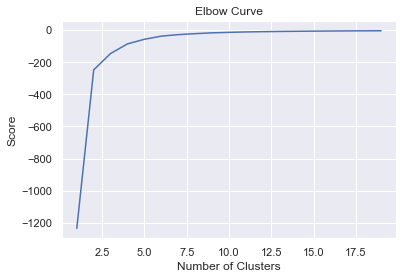

In [177]:
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
M=sanitation_complaints.loc[:,['latitude','longitude']]
M.dropna(axis=0,how='any',subset=['latitude','longitude'],inplace=True)
K_clusters = range(1,20)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = M[['latitude']]
X_axis = M[['longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

number of clusters defined at 4

In [178]:
kmeans = KMeans(n_clusters = 4, init ='k-means++')
N=inspect.loc[:,['latitude','longitude']]
kmeans.fit(M) # Compute k-means clustering.
N.dropna(axis=0,how='any',subset=['latitude','longitude'],inplace=True)
N['cluster_label'] = kmeans.fit_predict(N)
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
#labels = kmeans.predict(N) # Labels of each point

The idea is to locate restaurants inside sanitation_complaints clusters:

In [179]:
N.head()

latitude  longitude  cluster_label
4   41.795826 -87.760919              3
6   41.851823 -87.693128              1
7   41.936267 -87.661380              2
9   41.969394 -87.761887              0
10  41.706124 -87.713694              3

In [181]:
mapping = dict(N[['latitude', 'cluster_label']].values)
inspect['cluster_label'] = inspect.latitude.map(mapping)

In [182]:
inspect.head()

address                  aka_name     city  \
4       5857 S ARCHER AVE              LA MICHOACANA  CHICAGO   
6        2703 W CERMAK RD          HONG KONG EXPRESS  CHICAGO   
7   1300 W WELLINGTON AVE          FARM BAR LAKEVIEW  CHICAGO   
9    4859 N MILWAUKEE AVE                    KAWAYAN  CHICAGO   
10        3700 W 103RD ST   ST XAVIER MAIN CAFETERIA  CHICAGO   

              dba_name facility_type          inspection_date inspection_id  \
4        LA MICHOACANA    Restaurant  2020-12-10T00:00:00.000       2463607   
6    HONG KONG EXPRESS    Restaurant  2020-12-10T00:00:00.000       2463587   
7    FARM BAR LAKEVIEW    Restaurant  2020-12-10T00:00:00.000       2463586   
9          KAWAYAN LLC    Restaurant  2020-12-10T00:00:00.000       2463596   
10  COUNTRY HOUSE-MAIN    Restaurant  2020-12-10T00:00:00.000       2463594   

   inspection_type   latitude  license  \
4          Canvass  41.795826  2671508   
6          Canvass  41.851823  1621766   
7          Canvass  41.936267    47311   
9          Canvass  41.969394  2313831   
10         Canvass  41.706124  2464651   

                                             location  longitude  \
4   {'latitude': '-87.76091868735092', 'longitude'... -87.760919   
6   {'latitude': '-87.69312801384712', 'longitude'... -87.693128   
7   {'latitude': '-87.66137964487525', 'longitude'... -87.661380   
9   {'latitude': '-87.76188717239603', 'longitude'... -87.761887   
10  {'latitude': '-87.71369359633356', 'longitude'... -87.713694   

               results           risk state  \
4                 Pass  Risk 1 (High)    IL   
6   Pass w/ Conditions  Risk 1 (High)    IL   
7                 Pass  Risk 1 (High)    IL   
9                 Fail  Risk 1 (High)    IL   
10                Pass  Risk 1 (High)    IL   

                                           violations    zip   datetime  \
4                                                 NaN  60638 2020-12-10   
6   22. PROPER COLD HOLDING TEMPERATURES - Comment...  60608 2020-12-10   
7   49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Com...  60657 2020-12-10   
9   37. FOOD PROPERLY LABELED; ORIGINAL CONTAINER ...  60630 2020-12-10   
10  39. CONTAMINATION PREVENTED DURING FOOD PREPAR...  60655 2020-12-10   

   number_of_black_carts_delivered  cluster_label  
4                                1            3.0  
6                                2            1.0  
7                                0            2.0  
9                                1            0.0  
10                               0            3.0

Let's build the federated dataframe now, that is useful for data exploration:

In [183]:
data = inspect.loc[:, ["inspection_id", "license", "inspection_date", "facility_type","risk","number_of_black_carts_delivered","cluster_label"]]

data["pass_flag"] = inspect.results.apply(lambda x: 1 if x == "Pass" else 0)
data["fail_flag"] = inspect.results.apply(lambda x: 1 if x == "Fail" else 0)

# Merge with violation data, filtering missing data
data = pd.merge(data, values, on="inspection_id")
data = pd.merge(data, counts, on="inspection_id")

# Sort inspections by date
license_groups = data.sort_values("inspection_date").groupby("license")

# Find previous inspections 
past_data = license_groups.shift(1)

# Add past fails, with 0 for first inspections
data["past_fail"] = past_data.fail_flag.fillna(0)

# Add past violation counts
data["past_critical"] = past_data.critical_count.fillna(0)
data["past_serious"] = past_data.serious_count.fillna(0)
data["past_minor"] = past_data.minor_count.fillna(0)

In [184]:
# Select past violation values, remove past inspection id
past_values = past_data[values.columns].drop("inspection_id", axis=1).add_prefix("p")

# Add past values to model data, with 0 for first records
data = data.join(past_values.fillna(0))

# Calculate time since previous inspection
deltas = pd.to_datetime(data.inspection_date) - pd.to_datetime(past_data.inspection_date)

# Add years since previous inspection, with 2 for first records
data["time_since_last"] = deltas.apply(lambda x: x.days / 365.25).fillna(2)

# Check if first record
data["first_record"] = past_data.inspection_id.map(lambda x: 1 if pd.isnull(x) else 0)

In [185]:
def get_street_number(address):
    return address.split()[0]

business_licenses["street_number"] = business_licenses.address.apply(get_street_number)
inspect["street_number"] = inspect.address.apply(get_street_number)

# Match based on DBA name and street number
venue_matches = pd.merge(inspect, business_licenses, left_on=["dba_name", "street_number"], right_on=["doing_business_as_name", "street_number"])

# Match based on license numbers
license_matches = pd.merge(inspect, business_licenses, left_on="license", right_on="license_number")

# Join matches, reset index, drop duplicates
matches = venue_matches.append(license_matches, sort=False)
matches.reset_index(drop=True, inplace=True)
matches.drop_duplicates(["inspection_id", "id"], inplace=True)

# Restrict to matches where inspection falls within license period
matches = matches.loc[matches.inspection_date.between(matches.license_start_date, matches.expiration_date)]

# Select retail food establishment inspection IDs
retail = matches.loc[matches.license_description == "Retail Food Establishment", ["inspection_id"]]
retail.drop_duplicates(inplace=True)

# FILTER: ONLY CONSIDER INSPECTIONS MATCHED WITH RETAIL LICENSES
data = pd.merge(data, retail, on="inspection_id")
# Convert dates
matches.inspection_date = pd.to_datetime(matches.inspection_date)
matches.license_start_date = pd.to_datetime(matches.license_start_date)

def get_age_data(group):
    min_date = group.license_start_date.min()
    deltas = group.inspection_date - min_date
    group["age_at_inspection"] = deltas.apply(lambda x: x.days / 365.25)
    return group[["inspection_id", "age_at_inspection"]]

# drop duplicates
age_data = matches.groupby("license").apply(get_age_data).drop_duplicates()

# Merge in age_at_inspection
data = pd.merge(data, age_data, on="inspection_id", how="left")

In [186]:
# Translate categories to simple titles
categories = {
    "Consumption on Premises - Incidental Activity": "consumption_on_premises_incidental_activity",
    "Tobacco": "tobacco",
    "Package Goods": "package_goods",
    "Limited Business License": "limited_business_license",
    "Outdoor Patio": "outdoor_patio",
    "Public Place of Amusement": "public_place_of_amusement",
    "Children's Services Facility License": "childrens_services_facility_license",
    "Tavern": "tavern",
    "Regulated Business License": "regulated_business_license",
    "Filling Station": "filling_station",
    "Caterer's Liquor License": "caterers_liquor_license",
    "Mobile Food License": "mobile_food_license"
}

# Create binary markers for license categories
def get_category_data(group):
    df = group[["inspection_id"]].iloc[[0]]
    for category in group.license_description:
        if category in categories:
            df[categories[category]] = 1
    return df
    
# group by inspection
category_data = matches.groupby("inspection_id").apply(get_category_data)

# Reset index, set absent categories to 0
category_data.reset_index(drop=True, inplace=True)
category_data.fillna(0, inplace=True)

# Merge in category data
data = pd.merge(data, category_data, on="inspection_id", how="left").fillna(0)

In [187]:
data = pd.merge(data, thefts_kde, on="inspection_id")

In [188]:
data.head(2)

inspection_id  license          inspection_date facility_type  \
0       2463607  2671508  2020-12-10T00:00:00.000    Restaurant   
1       2463587  1621766  2020-12-10T00:00:00.000    Restaurant   

            risk number_of_black_carts_delivered  cluster_label  pass_flag  \
0  Risk 1 (High)                               1            3.0          1   
1  Risk 1 (High)                               2            1.0          0   

   fail_flag  v_1  ...  tobacco  caterers_liquor_license  \
0          0  0.0  ...      0.0                      0.0   
1          0  0.0  ...      0.0                      0.0   

   public_place_of_amusement  outdoor_patio  tavern  \
0                        0.0            0.0     0.0   
1                        0.0            0.0     0.0   

   childrens_services_facility_license  filling_station  \
0                                  0.0              0.0   
1                                  0.0              0.0   

   limited_business_license  mobile_food_license  thefts_kde  
0                       0.0                  0.0    2.889505  
1                       0.0                  0.0   16.116453  

[2 rows x 122 columns]

STEP II: EDA

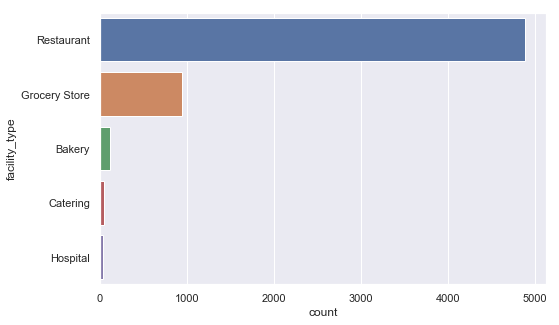

In [189]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.countplot(y='facility_type',data=data,order=data.facility_type.value_counts().iloc[:5].index)

we would keep only Restaurants and Grocery Stores but the nature of the problem need all information, especially if tree based algorithms will perform better

we check black_carts:

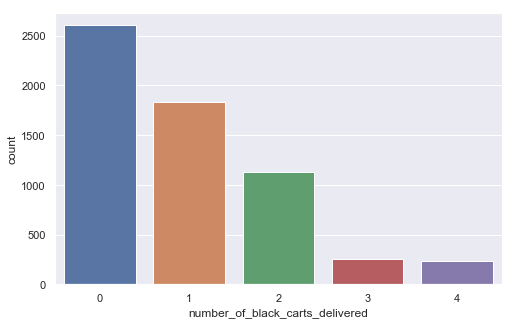

In [190]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.countplot(x='number_of_black_carts_delivered',data=data,order=data.number_of_black_carts_delivered.value_counts().iloc[:5].index)

sanitation clusters density:

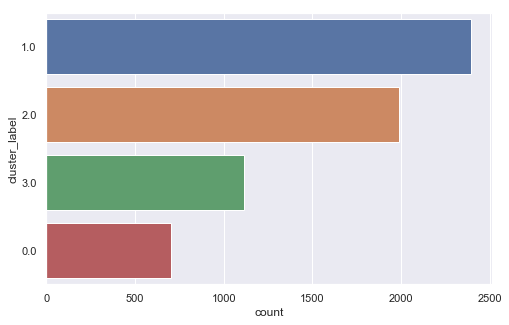

In [191]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.countplot(y='cluster_label',data=data,order=data.cluster_label.value_counts().iloc[:5].index)

We check for violations counts and if we have an insight there:

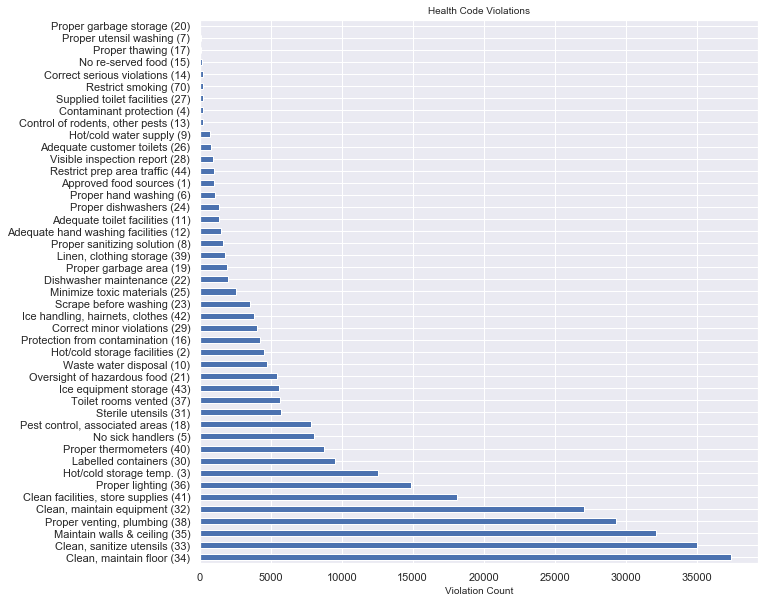

In [192]:
titled_values = values.rename(columns=titles.iloc[0])
sums = titled_values.drop("inspection_id", axis=1).sum()
sum_data = pd.DataFrame({"sums": sums}).sort_values("sums")


plt.rcParams['figure.figsize'] = (10, 10)
ax = sum_data.sums.plot(kind="barh")
ax.set_title("Health Code Violations", fontsize=10)
ax.set_xlabel("Violation Count", fontsize=10)
ax.invert_yaxis()
plt.show()

violations related to Cleaning are widely present, data regarding that such as garbage and water consumption would be good

we check our target variable

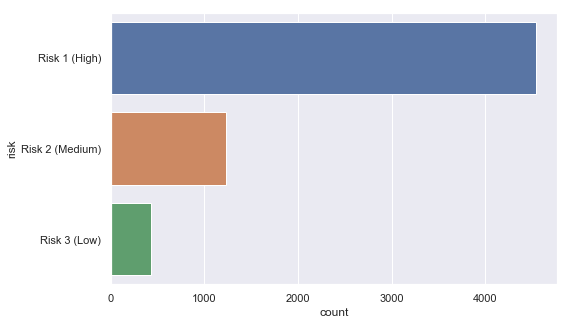

In [193]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.countplot(y='risk',data=data,order=data.risk.value_counts().iloc[:5].index)

some imbalance but we will fix that when time comes

The geographical aspect is important in this problem, we need to see those inspections in the field and have an idea about the density:

In [194]:
from folium import folium, plugins
from IPython.display import HTML

# Generate map
m = folium.Map([41.8600, -87.6298], zoom_start=10)
ins=inspect.dropna()
inspections_arr = ins.sample(70000)[["latitude", "longitude"]].values

m.add_child(plugins.HeatMap(inspections_arr.tolist(), radius=10))

Inspections are along the coast and near it. this is a problem for the data structure as we need a more global view

let's check for correlations:

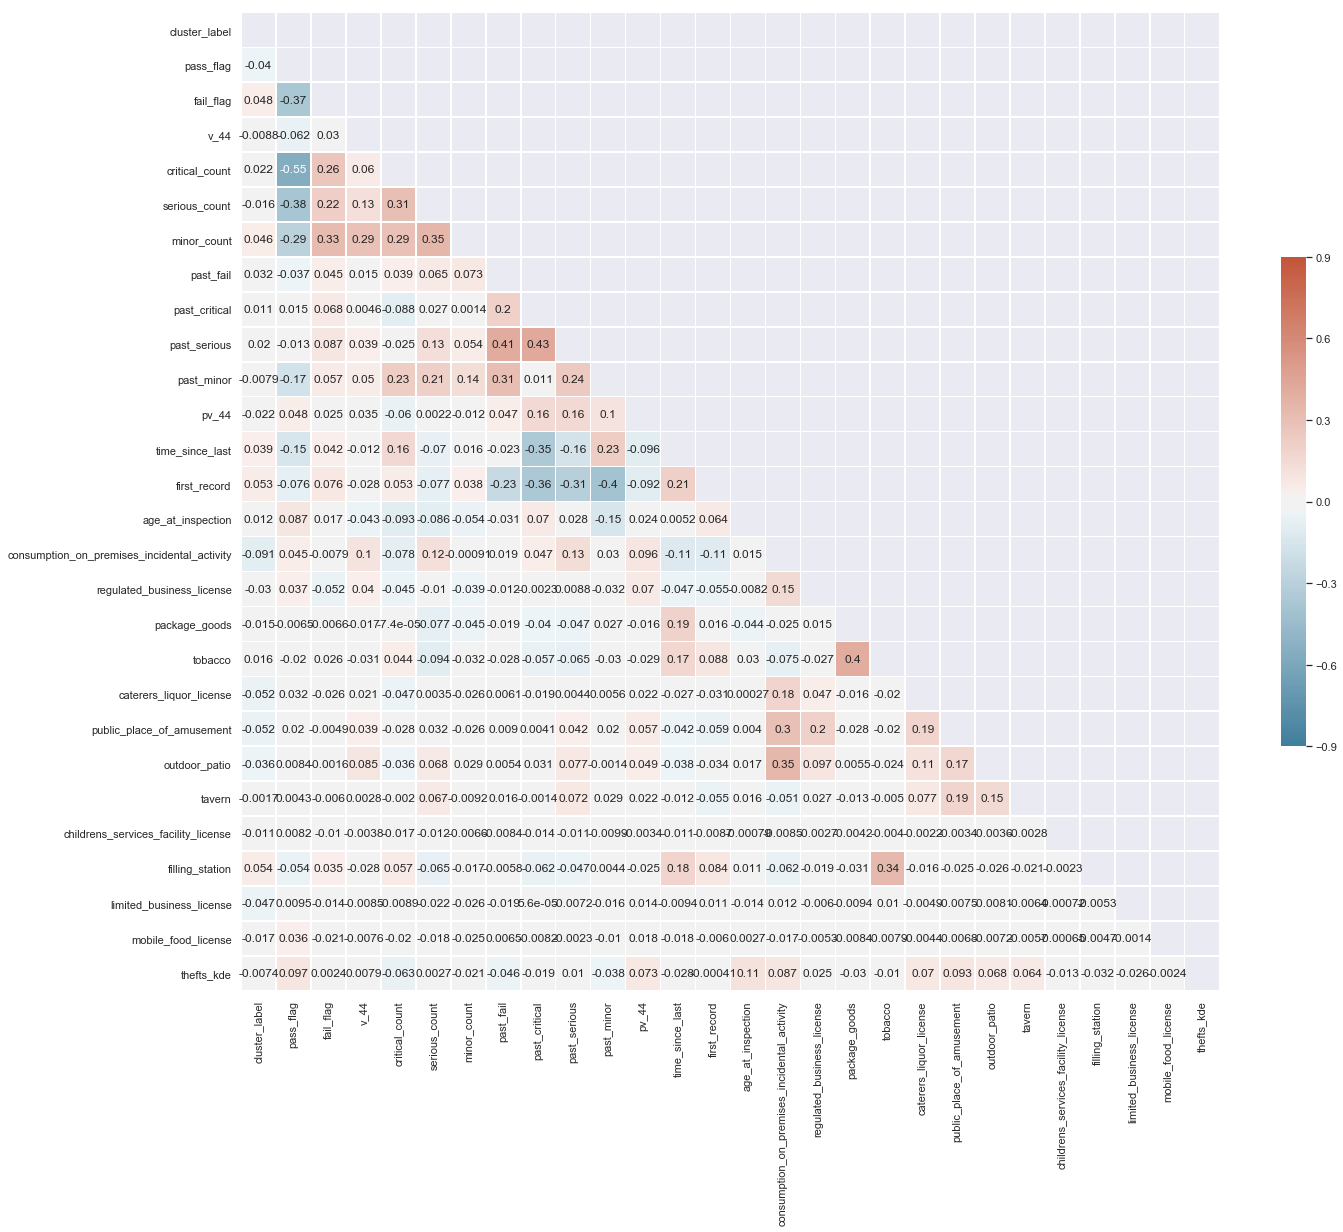

In [195]:
data_num=data.select_dtypes(include = ['float64', 'int64'])
for i in range(1,44):
    data_num=data_num.drop(['pv_'+str(i),'v_'+str(i)],axis=1)
    
data_num=data_num.drop(['pv_70'],axis=1)
data_num=data_num.drop(['v_70'],axis=1)
corr = data_num.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(22, 18))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-.9,vmax=.9, center=0,square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})

STEP III: Prediction Model

- Data Preparation:

In [196]:
main=data.drop(['inspection_id','license','inspection_date','pass_flag','fail_flag'],axis=1)
main=main.drop(['v_70'],axis=1)
for i in range(1,44):
    main=main.drop(['v_'+str(i)],axis=1)

we check data types and handle categorical features:

In [197]:
main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6196 entries, 0 to 6195
Data columns (total 73 columns):
facility_type                                  6196 non-null object
risk                                           6196 non-null object
number_of_black_carts_delivered                6196 non-null object
cluster_label                                  6196 non-null float64
v_44                                           6196 non-null float64
critical_count                                 6196 non-null float64
serious_count                                  6196 non-null float64
minor_count                                    6196 non-null float64
past_fail                                      6196 non-null float64
past_critical                                  6196 non-null float64
past_serious                                   6196 non-null float64
past_minor                                     6196 non-null float64
pv_1                                           6196 non-null float64

In [198]:
main = pd.concat([main,pd.get_dummies(data['facility_type'], prefix='ft')],axis=1)
main.drop(['facility_type','v_44'],axis=1)
main['number_of_black_carts_delivered']=main['number_of_black_carts_delivered'].astype(int)
main['cluster_label']=main['cluster_label'].astype(int)

In [199]:
#we drop highly correlated features
corr_matrix = main.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

to_drop = [column for column in upper.columns if any(abs(upper[column] > 0.8))]
main=main.drop(main[to_drop], axis=1)

In [200]:
#we check colinearity too
from statsmodels.stats.outliers_influence import variance_inflation_factor
def vif(n):
    vif = pd.DataFrame()
    vif["variables"] = n.columns
    vif["VIF"] = [variance_inflation_factor(n.values, i) for i in range(n.shape[1])]
    return(vif)

main_num=main.select_dtypes(include = ['float64', 'int64'])
X=main_num.iloc[:,:-1].dropna()

vif(X)

C:\Users\fbencheikh\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


variables       VIF
0                                          v_44  1.175765
1                                critical_count  2.387787
2                                 serious_count  1.886087
3                                   minor_count  2.180292
4                                     past_fail  2.122489
5                                 past_critical  4.834194
6                                  past_serious       inf
7                                    past_minor       inf
8                                          pv_1  1.356517
9                                          pv_2  1.666421
10                                         pv_4  1.021152
11                                         pv_6  1.071363
12                                         pv_7  1.062441
13                                         pv_8  1.105558
14                                         pv_9  1.109974
15                                        pv_10  1.906443
16                                        pv_11  1.078109
17                                        pv_12  1.151666
18                                        pv_13  1.043899
19                                        pv_14  1.047901
20                                        pv_15       inf
21                                        pv_16       inf
22                                        pv_17       inf
23                                        pv_18       inf
24                                        pv_19       inf
25                                        pv_20       inf
26                                        pv_21       inf
27                                        pv_22       inf
28                                        pv_23       inf
29                                        pv_24       inf
..                                          ...       ...
36                                        pv_31       inf
37                                        pv_32       inf
38                                        pv_33       inf
39                                        pv_34       inf
40                                        pv_35       inf
41                                        pv_36       inf
42                                        pv_37       inf
43                                        pv_38       inf
44                                        pv_39       inf
45                                        pv_40       inf
46                                        pv_41       inf
47                                        pv_42       inf
48                                        pv_43       inf
49                                        pv_44       inf
50                                        pv_70       inf
51                              time_since_last  4.274216
52                                 first_record  1.898938
53                            age_at_inspection  2.656651
54  consumption_on_premises_incidental_activity  1.653350
55                   regulated_business_license  1.088219
56                                package_goods  1.377101
57                                      tobacco  1.489518
58                      caterers_liquor_license  1.085953
59                    public_place_of_amusement  1.251687
60                                outdoor_patio  1.248712
61                                       tavern  1.146892
62          childrens_services_facility_license  1.001408
63                              filling_station  1.234804
64                     limited_business_license  1.006415
65                          mobile_food_license  1.013786

[66 rows x 2 columns]

No colinearity in sight with low VIF scores

- Data Preparation for ML algos:

In [217]:
main=main.drop(['facility_type'],axis=1)
X = main[main.columns.difference(['risk'])].values
y = main['risk'].values

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE


In [218]:
main.head(2)

risk  number_of_black_carts_delivered  cluster_label  v_44  \
0  Risk 1 (High)                                1              3   0.0   
1  Risk 1 (High)                                2              1   0.0   

   critical_count  serious_count  minor_count  past_fail  past_critical  \
0             0.0            0.0          0.0        0.0            0.0   
1             0.0            1.0          1.0        0.0            2.0   

   past_serious  ...  ft_Shared Kitchen  ft_Shelter  ft_Special Event  \
0           0.0  ...                  0           0                 0   
1           0.0  ...                  0           0                 0   

   ft_TAVERN  ft_Theater & Restaurant  ft_Wholesale  ft_banquets  \
0          0                        0             0            0   
1          0                        0             0            0   

   ft_convenience  ft_convenience/drug store  ft_gas station  
0               0                          0               0  
1               0                          0               0  

[2 rows x 148 columns]

In [219]:
# we do scaling and SMOTE to compensate the imbalance
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)
sm = SMOTE(random_state=3)
X, y = sm.fit_sample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

- ML Models screening:

1- Random Forest:

Accuracy: 92.36%


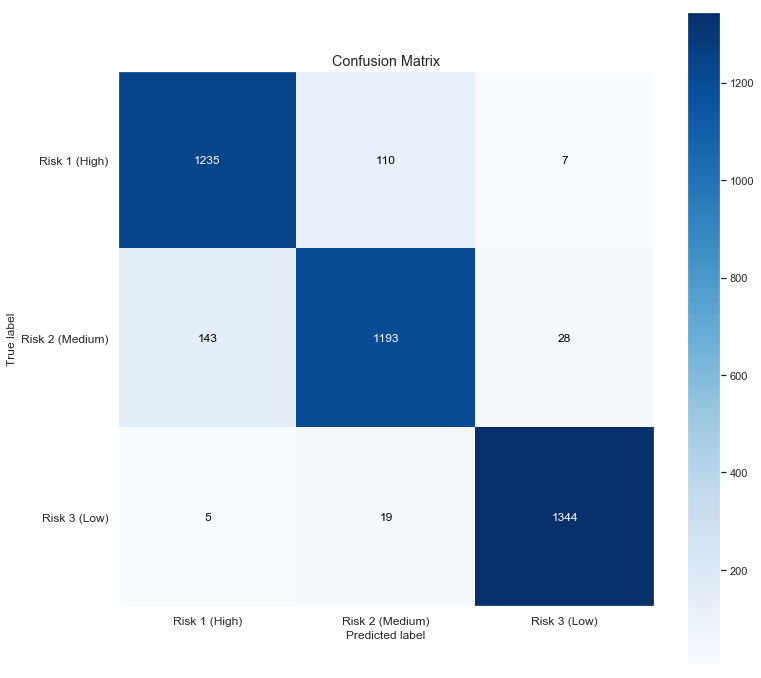

In [220]:
from sklearn.ensemble import RandomForestClassifier

classior = RandomForestClassifier(n_estimators=100, min_samples_split= 2,min_samples_leaf= 1,max_features='sqrt',max_depth=None,bootstrap=False,random_state=1)
classior.fit(X_train, y_train)
y_pred = classior.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred)*100))
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix( y_test,  y_pred, figsize=(12,12))

2- XGBoost:

In [221]:
import xgboost as xgb
from xgboost import XGBClassifier

model = XGBClassifier(max_depth=50, learning_rate=0.01, n_estimators=100, gamma=0.1, 
                        min_child_weight=1, subsample=1, colsample_bytree=1, reg_alpha=0.08)

model.fit(X_train, y_train)
preds = model.predict(X_test)

#accuracy = (preds == y_test).sum().astype(float) / len(preds)*100

# evaluate predictions
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 89.13%


3- Logistic Regression:

In [225]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
predictions = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, y_test)
print("Accuracy: %.2f%%" % (score * 100.0))

Accuracy: 81.00%


C:\Users\fbencheikh\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


4- Multilayer Perceptron:

In [228]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
clf = MLPClassifier(random_state=1, max_iter=600).fit(X_train, y_train)
clf.predict(X_test)
clf.score(X_test, y_test)

0.9027913809990206

5- LGBM:

In [229]:
import lightgbm as lgb
lgbm = lgb.LGBMClassifier()
lgbm.fit(X_train, y_train)
y_predlgbm=lgbm.predict(X_test)
accuracy=accuracy_score(y_predlgbm, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_predlgbm)))

LightGBM Model accuracy score: 0.9013


Random Forest seems to be the most performant model now. Let's fine tune the parameters in hope to enhance the model with cross validation:

- The Model:

In [230]:
#some randomized search with cross validation to enhance the CLASSOR
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 4, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 43.4min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed: 48.1min finished


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [231]:
rf_random.best_params_

{'n_estimators': 1366,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': False}

Accuracy: 92.34%


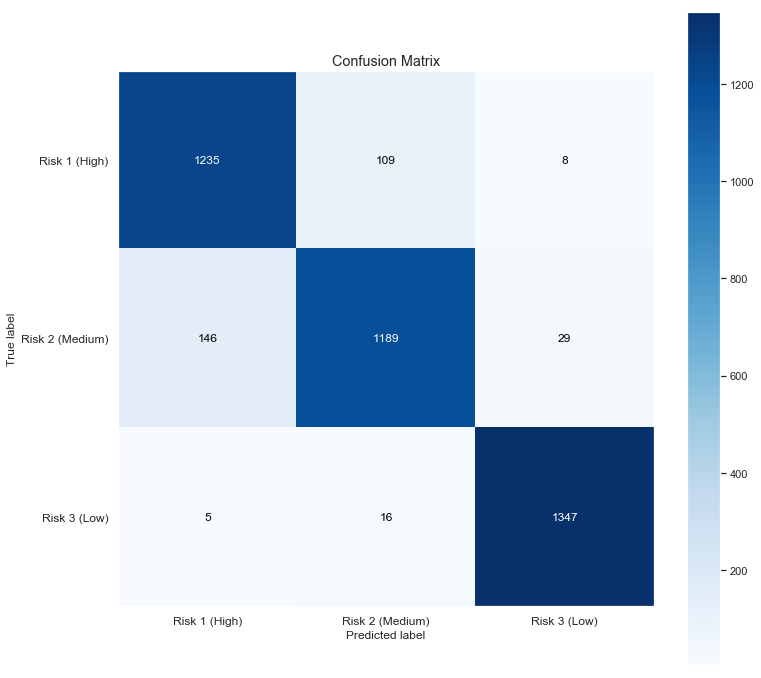

In [233]:
classor = RandomForestClassifier(n_estimators=136, min_samples_split= 2,min_samples_leaf= 1,max_features='auto',max_depth=100,bootstrap=False,random_state=1)
classor.fit(X_train, y_train)
y_pred = classor.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Accuracy: %.2f%%" % (accuracy_score(y_test, y_pred)*100))
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix( y_test,  y_pred, figsize=(12,12))

LET'S CHECK FOR THOSE KEY FEATURES:

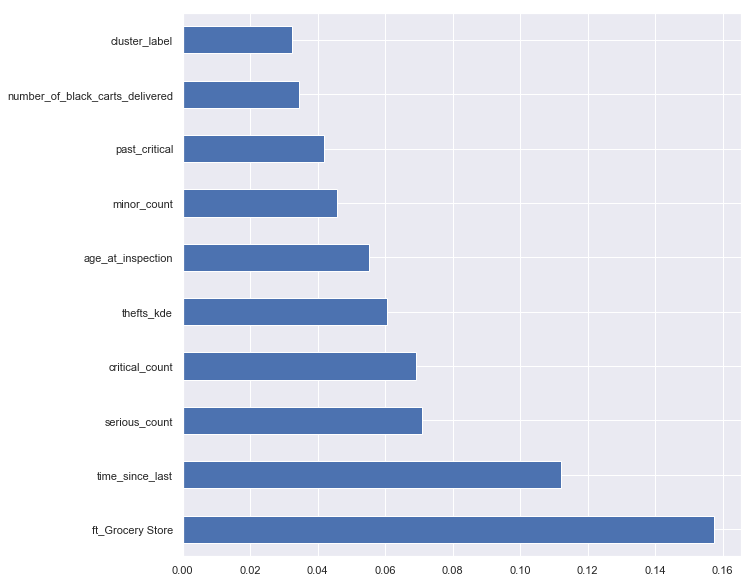

In [234]:
feat_importances = pd.Series(classor.feature_importances_, index=main[main.columns.difference(['risk'])].columns)
feat_importances.nlargest(10).plot(kind='barh')

In [235]:
predictions=pd.DataFrame(y_pred)

In [236]:
predictions[0].value_counts()

Risk 1 (High)      1386
Risk 3 (Low)       1384
Risk 2 (Medium)    1314
Name: 0, dtype: int64

In [237]:
risk_high=predictions[0].value_counts()[0]
risk_low=predictions[0].value_counts()[1]
risk_med=predictions[0].value_counts()[2]

We have now our outputs to feed the linear optimization solver.

- Optimization Solving:

- Linear Approch:

In [238]:
from scipy.optimize import linprog
#maximization of revenues from inspections
objctive_function = [-1, -2, -3]

#Inequalities/constraints based on problem assumptions
lhs_ineq = [[ -1,  -1, -1],[ 1,  -1, -3],[1,  0, 0],[0,  1, 0],[ 1,  1, 1]]
rhs_ineq = [-12*30,0,risk_low,risk_med,12*5*30]
bnd = [(0, float("inf")),(0, float("inf")),(0, float("inf"))]

#equality based on the fact that we need to check all high risk restaurants
lhs_eq = [[0, 0,1]]  # Green constraint left side
rhs_eq = int(0.9*risk_high)

In [239]:
opt = linprog(c=objctive_function, A_ub=lhs_ineq, b_ub=rhs_ineq, A_eq=lhs_eq, b_eq=rhs_eq,bounds=bnd,method="revised simplex")

In [240]:
opt

     con: array([0.])
     fun: -4847.0
 message: 'Optimization terminated successfully.'
     nit: 1
   slack: array([1440., 4294., 1384.,  761.,    0.])
  status: 0
 success: True
       x: array([   0.,  553., 1247.])

In [241]:
print("Revenue gained from inspections this month is predicted to be:",opt.x[0]*200+opt.x[1]*400+opt.x[2]*600)
print("Cost of inspections this month is predicted to be:",300*(opt.x[0]+opt.x[1]+opt.x[2]))
print("Profit to make:", opt.x[0]*200+opt.x[1]*400+opt.x[2]*600 - 300*(opt.x[0]+opt.x[1]+opt.x[2]))

Revenue gained from inspections this month is predicted to be: 969400.0
Cost of inspections this month is predicted to be: 540000.0
Profit to make: 429400.0
